In [1]:
USER = 'Andrea'

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/Shareddrives/Project_ML_23/' + USER + '/machine-learning-project'
    sys.path.insert(0,BASE_PATH)
    #N_JOBS = 1
    sys.path.insert(0,BASE_PATH + '/src/utils')
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
    
    IMAGES_DIR = os.path.join(BASE_PATH, 'images', 'cup2023', 'cool_plots')
    
    MODELS_DIR = os.path.join(BASE_PATH, 'trained_models', 'cup2023')

else :
    #N_JOBS = -1
    
    TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')

    IMAGES_DIR = os.path.join('..', '..', 'images', 'cup2023', 'cool_plots')

    MODELS_DIR = os.path.join('..', '..', 'trained_models', 'cup2023')

RF_MODEL = os.path.join(MODELS_DIR, 'random_forest_model.joblib')
SVM_MODEL = os.path.join(MODELS_DIR, 'SVR_model.joblib')
NN_MODEL = os.path.join(MODELS_DIR, 'NN_model.joblib')

In [3]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + '/src/utils')
else:
    sys.path.append('../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from utils import save_plot

2024-01-22 19:20:33.189557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 19:20:33.189591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 19:20:33.190464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 19:20:33.195737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 19:20:33.943469: W tensorflow/compiler/tf2

## Data processing

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') # casting
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [5]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [6]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

# Use seed 42 to have the same split we used in our models
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#test_indices = np.where(np.isin(y, y_true))[0]

In [7]:
print(y_test.shape)
#print(test_indices.shape)
print(y_test.shape[0])

(200, 3)
200


In [8]:
from joblib import load

svm = load(SVM_MODEL)
rf = load(RF_MODEL)
nn = load(NN_MODEL)

/home/andrea/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/andrea/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVR from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/andrea/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead 

ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

In [ ]:
# Predictions of the models
y_pred_rf = rf.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_nn = nn.predict(X_test)

Warning! I create fake predictions to test the plots

In [10]:
# WARNING! Since the above imports do not work, I create fake predictions by 
# adding random noise to the true values

y_pred_rf = y_test + np.random.normal(1, 5, size=y_test.shape)
y_pred_svm = y_test + np.random.normal(-1, 2, size=y_test.shape)
y_pred_nn = y_test + np.random.normal(2, 10, size=y_test.shape)

## Individual coordinates scatter plot

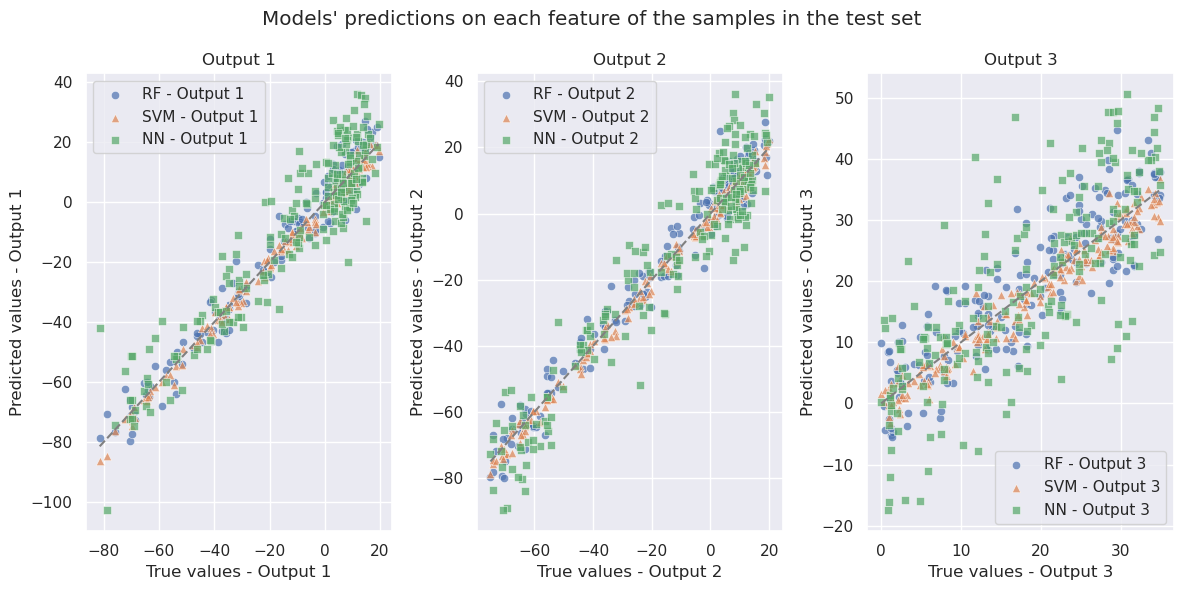

In [12]:
plt.figure(figsize=(12,6))

for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=y_test[:,i], y=y_pred_rf[:,i], label=f'RF - Output {i+1}', marker='o', alpha=0.7)
    sns.scatterplot(x=y_test[:,i], y=y_pred_svm[:,i], label=f'SVM - Output {i+1}', marker='^', alpha=0.7)
    sns.scatterplot(x=y_test[:,i], y=y_pred_nn[:,i], label=f'NN - Output {i+1}', marker='s', alpha=0.7)
    
    plt.plot([min(y_test[:,i]), max(y_test[:,i])], [min(y_test[:,i]), max(y_test[:,i])], linestyle='--', color='gray')
    
    plt.xlabel(f'True values - Output {i+1}')
    plt.ylabel(f'Predicted values - Output {i+1}')
    plt.title(f'Output {i+1}')

plt.suptitle("Models' predictions on each feature of the samples in the test set")
plt.tight_layout()
plt.legend()
save_plot(plt, IMAGES_DIR, 'individual_coordinates_scatterplot')
plt.show()

## Contributions to MEE

/home/andrea/anaconda3/envs/ML-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/andrea/anaconda3/envs/ML-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/andrea/anaconda3/envs/ML-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/andrea/anaconda3/envs/ML-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

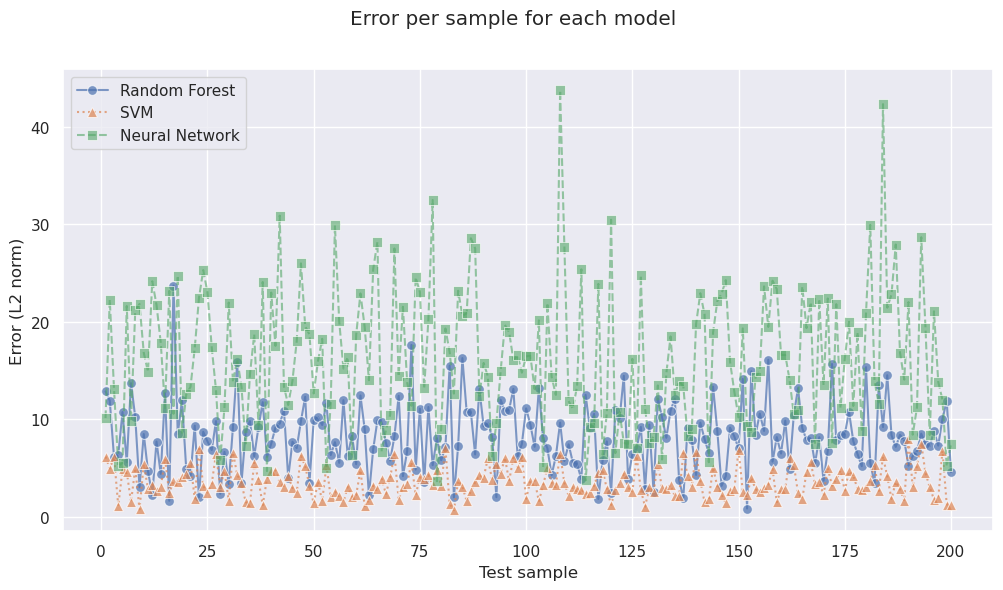

In [14]:
plt.figure(figsize=(12,6))

sns.lineplot(x=range(1,y_test.shape[0]+1), y=[np.linalg.norm((y_test-y_pred_rf)[i,:]) for i in range(y_test.shape[0])], label='Random Forest', linestyle='-', marker='o', markersize=7, alpha=0.7)
sns.lineplot(x=range(1,y_test.shape[0]+1), y=[np.linalg.norm((y_test-y_pred_svm)[i,:]) for i in range(y_test.shape[0])], label='SVM', linestyle=':', marker='^', markersize=7, alpha=0.7)
sns.lineplot(x=range(1,y_test.shape[0]+1), y=[np.linalg.norm((y_test-y_pred_nn)[i,:]) for i in range(y_test.shape[0])], label='Neural Network', linestyle='--', marker='s', markersize=7, alpha=0.6)


plt.xlabel('Test sample')
plt.ylabel('Error (L2 norm)')
plt.suptitle('Error per sample for each model')

#plt.tight_layout()
plt.legend()
save_plot(plt, IMAGES_DIR, 'error_per_sample')
plt.show()

## 3D scatter plot

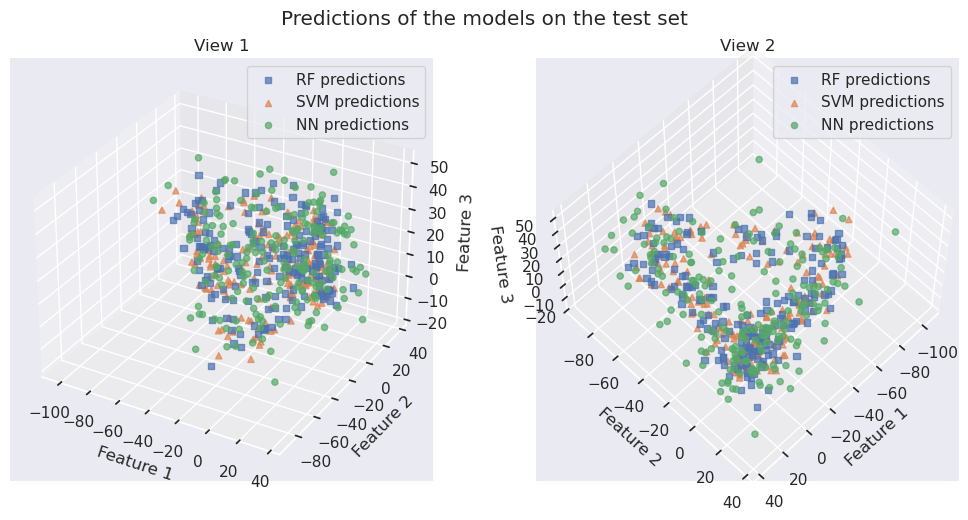

In [36]:
# TODO: best fit surface, representing the available data
# Of course, obtaining a best fit surface is a task in itself which deserves a lot of discussion
# but we just want to show the data we have

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,5))

#first subplot
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(y_pred_rf[:,0], y_pred_rf[:,1], y_pred_rf[:,2], label='RF predictions', marker='s', alpha=0.7)
ax1.scatter(y_pred_svm[:,0], y_pred_svm[:,1], y_pred_svm[:,2], label='SVM predictions', marker='^', alpha=0.7)
ax1.scatter(y_pred_nn[:,0], y_pred_nn[:,1], y_pred_nn[:,2], label='NN predictions', marker='o', alpha=0.7)

ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')


ax1.set_title('View 1')
ax1.legend()

#second subplot: another view of the same plot
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(y_pred_rf[:,0], y_pred_rf[:,1], y_pred_rf[:,2], label='RF predictions', marker='s', alpha=0.7)
ax2.scatter(y_pred_svm[:,0], y_pred_svm[:,1], y_pred_svm[:,2], label='SVM predictions', marker='^', alpha=0.7)
ax2.scatter(y_pred_nn[:,0], y_pred_nn[:,1], y_pred_nn[:,2], label='NN predictions', marker='o', alpha=0.7)

ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')

ax2.view_init(elev=60, azim=45)

ax2.set_title('View 2')
ax2.legend()

plt.suptitle('Predictions of the models on the test set')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

save_plot(plt, IMAGES_DIR, '3d_scatterplot')
plt.show()
